In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from tqdm import tqdm
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

In [4]:
MAX_LENGTH = 15

In [2]:
def generate_random_alphabet_index():
    random_length = np.random.randint(10, MAX_LENGTH-2)    # -2 because of <s> and </s>
    random_alphabet_index = np.random.randint(0, 26, random_length) + 3
    return random_alphabet_index.tolist(), random_length

In [5]:
generate_random_alphabet_index()

([14, 6, 17, 16, 28, 19, 10, 12, 9, 4, 4, 13], 12)

In [6]:
generate_random_alphabet_index()

([25, 25, 26, 23, 10, 11, 7, 16, 10, 3, 20], 11)

## 알파벳 시퀀스 역정렬 데이터를 위한 데이터셋 클래스 정의하기

In [7]:
from torch.utils.data import Dataset

class AlphabetToyDataset(Dataset):
    def __init__(self, n_dataset=1000):
        bos = 0
        eos = 1
        pad = 2
        self.inputs = []
        self.labels = []
        self.length = []
        for _ in range(n_dataset):
            # make input example
            aindex, alen = generate_random_alphabet_index()
            
            # index to alphabet
            #alphabet = list(map(lambda a: i2a[a], aindex))
            
            # inversing
            #inversed_alphabet = list(map(lambda a: inverse_map[a], alphabet))
            
            # alphabet to index
            #iindex = list(map(lambda ia: a2i[ia], inversed_alphabet))
            iindex = aindex[::-1]
            
            # add bos, eos and pad
            n_pad = MAX_LENGTH - len(aindex) - 1
            aindex = aindex + [eos] + [pad]*n_pad
            iindex = iindex + [eos] + [pad]*n_pad
            
            # add to examples
            self.inputs.append(aindex)
            self.labels.append(iindex)
            self.length.append(alen)
            
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, index):
        return [
            torch.tensor(self.inputs[index], dtype=torch.long),
            torch.tensor(self.labels[index], dtype=torch.long),
            torch.tensor(self.length[index], dtype=torch.long)
        ]

In [8]:
train_dataset = AlphabetToyDataset(n_dataset=3000)
valid_dataset = AlphabetToyDataset(n_dataset=300)

### 알파벳 시퀀스 역정렬 데이터를 위한 데이터로더 생성하기

In [9]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

def collate_fn(batch):
    inputs = pad_sequence([b[0] for b in batch], batch_first=True)
    targets = pad_sequence([b[1] for b in batch], batch_first=True)
    lengths = torch.stack([b[2] for b in batch])

    lengths, indice = torch.sort(lengths, descending=True)
    inputs = inputs[indice]
    targets = targets[indice]
    return inputs, targets, lengths

In [10]:
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=16)
valid_dataloader = DataLoader(valid_dataset, collate_fn=collate_fn, batch_size=1)

### 알파벳 시퀀스 역정렬 데이터를 위한 데이터로더 테스트하기

In [11]:
for d in train_dataloader:
    inputs, targets, lengths = d
    print(inputs)
    print(targets)
    print(lengths)
    print(inputs.shape, targets.shape, lengths.shape)
    break

tensor([[ 4,  6, 24, 15,  5, 17, 26,  7, 27, 27, 19, 14,  1,  2,  2],
        [12, 22, 21, 27, 25,  9, 13, 16, 21, 16, 18,  3,  1,  2,  2],
        [24, 28, 15, 18,  4, 23, 28,  7, 28, 19, 23,  6,  1,  2,  2],
        [ 9,  3,  8, 10, 13,  3, 11,  7, 23, 25, 17,  1,  2,  2,  2],
        [ 3,  3, 28, 10, 13, 13, 15, 12,  6, 18, 26,  1,  2,  2,  2],
        [24, 14, 20, 25,  5, 16, 16, 14,  9, 28, 17,  1,  2,  2,  2],
        [26, 19,  5, 25, 12, 12,  6,  7, 18, 11,  7,  1,  2,  2,  2],
        [20, 17, 10, 24, 28, 26, 16, 11,  3, 10,  3,  1,  2,  2,  2],
        [10, 17, 15, 18, 25, 13, 26, 18,  6,  5,  7,  1,  2,  2,  2],
        [ 6, 26, 14,  6, 24, 24, 27, 15, 15, 10, 14,  1,  2,  2,  2],
        [ 3, 13, 16, 24,  7, 20, 18, 21, 27,  7,  1,  2,  2,  2,  2],
        [15,  7, 17, 13, 11, 17, 15, 26, 22, 16,  1,  2,  2,  2,  2],
        [20, 10, 15, 10, 13, 15, 20,  3, 25,  4,  1,  2,  2,  2,  2],
        [11, 28, 20,  8, 19,  3, 13,  9,  9,  3,  1,  2,  2,  2,  2],
        [18, 20, 25,

### 알파벳 시퀀스를 역정렬하기 위한 Seq2Seq 모델 정의

In [12]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)

    def forward(self, inputs, hidden):
        '''
        Input Parameters
        - inputs: (B,M)
        - hidden: (1,B,H)
        
        Output returns
        - output: (B,M,H)
        - hidden: (1,B,H)
        
        Logging outputs
        ** inputs: torch.Size([16, 5])
        ** hidden: torch.Size([1, 16, 256])
        ** embedded: torch.Size([16, 5, 256])
        ** final-output: torch.Size([16, 5, 256])
        ** final-hidden: torch.Size([1, 16, 256])
        '''
        #print('** inputs: {}'.format(inputs.shape))
        #print('** hidden: {}'.format(hidden.shape))
        embedded = self.embedding(inputs)    # (B,M,H)
        #print('** embedded: {}'.format(embedded.shape))
        output, hidden = self.gru(embedded, hidden)    # (B,M,H), (1,B,H)
        #print('** final-output: {}'.format(output.shape))
        #print('** final-hidden: {}'.format(hidden.shape))
        return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

In [13]:
# with attention
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size, batch_first=True)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, inputs, hidden, encoder_outputs):
        '''
        Input Parameters
        - inputs: (B,1)
        - hidden: (1,B,H)
        - encoder_outputs: (B,M,H)
        
        Output returns
        - output: (B,1,O)
        - hidden: (B,1,H)
        - attn_weights: (B,1,M)
        
        Logging outputs
        ** inputs: torch.Size([16, 1])
        ** hidden: torch.Size(v[1, 16, 256])
        ** encoder_outputs: torch.Size([16, 15, 256])
        ** embedded: torch.Size([16, 1, 256])
        ** attn_weights: torch.Size([16, 1, 15])
        ** attn_weights: tensor([[[0.1068, 0.0260, 0.0466, 0.0421, 0.0885, 0.0843, 0.0718, 0.0575,
                  0.0361, 0.0273, 0.0339, 0.1882, 0.0606, 0.0723, 0.0581]],

                [[0.1634, 0.0374, 0.0518, 0.0382, 0.0771, 0.0577, 0.0624, 0.0658,
                  0.0286, 0.0351, 0.0336, 0.1435, 0.0603, 0.0940, 0.0510]],

                [[0.1191, 0.0284, 0.0447, 0.0361, 0.0816, 0.0879, 0.0675, 0.0523,
                  0.0293, 0.0273, 0.0535, 0.1981, 0.0588, 0.0728, 0.0427]],

                [[0.1043, 0.0357, 0.0479, 0.0426, 0.1006, 0.0658, 0.0556, 0.0538,
                  0.0372, 0.0476, 0.0348, 0.1877, 0.0641, 0.0705, 0.0516]],

                [[0.1179, 0.0354, 0.0404, 0.0565, 0.0785, 0.0645, 0.0700, 0.0685,
                  0.0380, 0.0414, 0.0456, 0.1519, 0.0710, 0.0682, 0.0523]],

                [[0.1363, 0.0500, 0.0404, 0.0383, 0.0748, 0.0674, 0.0733, 0.0520,
                  0.0288, 0.0306, 0.0466, 0.1517, 0.0769, 0.0932, 0.0395]],

                [[0.1429, 0.0315, 0.0380, 0.0411, 0.0754, 0.0555, 0.0701, 0.0626,
                  0.0337, 0.0311, 0.0398, 0.1486, 0.0813, 0.0885, 0.0599]],

                [[0.1183, 0.0333, 0.0422, 0.0445, 0.0842, 0.0600, 0.0854, 0.0732,
                  0.0299, 0.0447, 0.0299, 0.1091, 0.0865, 0.0831, 0.0757]],

                [[0.1145, 0.0353, 0.0372, 0.0386, 0.0867, 0.0568, 0.0840, 0.0514,
                  0.0393, 0.0285, 0.0397, 0.1800, 0.0759, 0.0755, 0.0565]],

                [[0.1614, 0.0251, 0.0357, 0.0470, 0.0903, 0.0756, 0.0521, 0.0419,
                  0.0305, 0.0227, 0.0343, 0.1683, 0.0643, 0.0891, 0.0616]],

                [[0.1152, 0.0248, 0.0413, 0.0535, 0.0836, 0.0599, 0.0707, 0.0559,
                  0.0333, 0.0394, 0.0348, 0.1688, 0.0728, 0.0880, 0.0582]],

                [[0.1475, 0.0310, 0.0462, 0.0446, 0.0865, 0.0484, 0.0775, 0.0775,
                  0.0378, 0.0357, 0.0360, 0.1070, 0.0689, 0.1070, 0.0485]],

                [[0.1168, 0.0299, 0.0347, 0.0407, 0.0787, 0.0605, 0.0683, 0.0517,
                  0.0312, 0.0334, 0.0426, 0.1895, 0.0739, 0.0914, 0.0565]],

                [[0.1122, 0.0315, 0.0371, 0.0409, 0.1061, 0.0805, 0.0861, 0.0475,
                  0.0399, 0.0262, 0.0330, 0.1467, 0.0676, 0.0788, 0.0660]],

                [[0.1491, 0.0363, 0.0410, 0.0398, 0.0919, 0.0586, 0.0605, 0.0647,
                  0.0378, 0.0277, 0.0356, 0.1396, 0.0699, 0.0981, 0.0495]],

                [[0.1127, 0.0238, 0.0486, 0.0385, 0.0809, 0.0726, 0.0829, 0.0495,
                  0.0441, 0.0275, 0.0412, 0.1654, 0.0627, 0.0825, 0.0672]]],
               device='cuda:0', grad_fn=<SoftmaxBackward>)
        ** attn_weights.sum(): torch.Size([])
        ** attn_weights.sum(): 16.0000
        ** attn_applied: torch.Size([16, 1, 256])
        ** output: torch.Size([16, 1, 512])
        ** output: torch.Size([16, 1, 256])
        ** output: torch.Size([16, 1, 256])
        ** hidden: torch.Size([1, 16, 256])
        ** gru-output: torch.Size([16, 1, 256])
        ** gru-hidden: torch.Size([1, 16, 256])
        ** final-output: torch.Size([16, 1, 29])
        ** final-hidden: torch.Size([1, 16, 256])
        ** final-attn_weights: torch.Size([16, 1, 15])
        '''
        embedded = self.embedding(inputs)    # (B,1,H)
        embedded = self.dropout(embedded)
        
        # query: embedded
        # key: hidden
        # value: encoder_outputs
        
        attn_weights = F.softmax(
            self.attn(
                torch.cat((embedded, hidden.transpose(0, 1)), -1)    # (B,1,2H)
            ),    # (B,1,M)
            dim=-1)    # (B,1,M)
        #print('** attn_weights: {}'.format(attn_weights.shape))
        #print('** attn_weights: {}'.format(attn_weights))
        #print('** attn_weights.sum(): {}'.format(attn_weights.sum().shape))
        #print('** attn_weights.sum(): {:.4f}'.format(attn_weights.sum()))
        
        attn_applied = torch.bmm(attn_weights, encoder_outputs)    # (B,1,H)
        #print('** attn_applied: {}'.format(attn_applied.shape))
        #return

        output = torch.cat((embedded, attn_applied), -1)    # (B,1,2H)
        #print('** output: {}'.format(output.shape))
        output = self.attn_combine(output)    # (B,1,H)
        #print('** output: {}'.format(output.shape))    # (B,1,H)
        
        output = F.relu(output)
        #print('** output: {}'.format(output.shape))    # (B,1,H)
        #print('** hidden: {}'.format(hidden.shape))    # (B,1,H)
        output, hidden = self.gru(output, hidden)    # (B,1,H) (1,B,H)
        #print('** gru-output: {}'.format(output.shape))
        #print('** gru-hidden: {}'.format(hidden.shape))

        output = F.log_softmax(self.out(output), dim=-1)
        #print('** final-output: {}'.format(output.shape))
        #print('** final-hidden: {}'.format(hidden.shape))
        #print('** final-attn_weights: {}'.format(attn_weights.shape))
        return output, hidden, attn_weights

    def initHidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

### 모델링 학습하기

In [26]:
bos = 0
eos = 1
pad = 2
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH, with_attention=True):
    batch_size = input_tensor.size(0)
    encoder_hidden = encoder.initHidden(batch_size)

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(1)
    target_length = target_tensor.size(1)
    
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    loss = 0

    encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden)
    
    decoder_input = torch.tensor([bos]*batch_size, device=device)
    decoder_input = decoder_input.unsqueeze(-1)    # (B,1)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if np.random.random() < teacher_forcing_ratio else False
    
    for di in range(target_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input,    # (B,1)
            decoder_hidden,   # (1,B,H)
            encoder_outputs   # (B,M,H)
        )
        decoder_output = decoder_output.squeeze(1)
        
        loss += criterion(decoder_output, target_tensor[:,di])
        
        if use_teacher_forcing:
            decoder_input = target_tensor[:,di].unsqueeze(-1)    # (B,1)
        else:
            topv, topi = decoder_output.topk(1)
            decoder_input = topi    # (B,1)

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [31]:
!pip install matplotlib

     ---------------------------------------- 7.2/7.2 MB 41.8 MB/s eta 0:00:00
     ------------------------------------- 944.1/944.1 kB 58.4 MB/s eta 0:00:00
     ---------------------------------------- 3.3/3.3 MB 52.7 MB/s eta 0:00:00
     ---------------------------------------- 55.4/55.4 kB ? eta 0:00:00


In [32]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # 주기적인 간격에 이 locator가 tick을 설정
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [28]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01, with_attention=True):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # print_every 마다 초기화
    plot_loss_total = 0  # plot_every 마다 초기화

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for iter, batch in enumerate(train_dataloader):
        input_tensor, target_tensor, length_tensor = batch
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)
        length_tensor = length_tensor.to(device)
        
        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion, with_attention=with_attention)
        print_loss_total += loss
        plot_loss_total += loss

        if (iter+1) % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, (iter+1) / n_iters),
                                         (iter+1), (iter+1) / n_iters * 100, print_loss_avg))

        if (iter+1) % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

### 알파벳 시퀀스 역정렬 모델 정의 후 학습하기

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [18]:
hidden_size = 256
encoder1 = EncoderRNN(26+3, hidden_size).to(device)
decoder1 = AttnDecoderRNN(hidden_size, 26+3, dropout_p=0.1).to(device)

In [33]:
for _ in range(15):
    trainIters(encoder1, decoder1, 75000, print_every=30, with_attention=True)

0m 1s (- 48m 53s) (30 0%) 2.6740
0m 2s (- 49m 33s) (60 0%) 2.6729
0m 3s (- 49m 18s) (90 0%) 2.6001
0m 4s (- 49m 30s) (120 0%) 2.6756
0m 5s (- 49m 48s) (150 0%) 2.5319
0m 7s (- 49m 58s) (180 0%) 2.6062
0m 1s (- 52m 23s) (30 0%) 2.5435
0m 2s (- 55m 1s) (60 0%) 2.5840
0m 3s (- 54m 31s) (90 0%) 2.4853
0m 5s (- 54m 9s) (120 0%) 2.5046
0m 6s (- 54m 11s) (150 0%) 2.4580
0m 7s (- 53m 41s) (180 0%) 2.5192
0m 1s (- 51m 46s) (30 0%) 2.4439
0m 2s (- 51m 13s) (60 0%) 2.4315
0m 3s (- 51m 40s) (90 0%) 2.3657
0m 4s (- 51m 30s) (120 0%) 2.3063
0m 6s (- 51m 16s) (150 0%) 2.2104
0m 7s (- 51m 21s) (180 0%) 2.0872
0m 1s (- 51m 21s) (30 0%) 1.8006
0m 2s (- 50m 15s) (60 0%) 1.6237
0m 3s (- 50m 22s) (90 0%) 1.5071
0m 4s (- 50m 40s) (120 0%) 1.2289
0m 6s (- 50m 47s) (150 0%) 1.2352
0m 7s (- 50m 52s) (180 0%) 0.9033
0m 1s (- 50m 36s) (30 0%) 0.5954
0m 2s (- 49m 53s) (60 0%) 0.5661
0m 3s (- 50m 11s) (90 0%) 0.3719
0m 4s (- 50m 37s) (120 0%) 0.3193
0m 6s (- 50m 54s) (150 0%) 0.6432
0m 7s (- 51m 47s) (180 0%) 0.40

C:\Users\ziipp\AppData\Local\Temp\ipykernel_31920\734353137.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


0m 1s (- 48m 58s) (30 0%) 0.1040
0m 2s (- 49m 50s) (60 0%) 0.0834
0m 3s (- 49m 55s) (90 0%) 0.0693
0m 4s (- 49m 48s) (120 0%) 0.0899
0m 5s (- 49m 52s) (150 0%) 0.0935
0m 7s (- 49m 40s) (180 0%) 0.0837
0m 1s (- 49m 43s) (30 0%) 0.0874
0m 2s (- 50m 2s) (60 0%) 0.0807
0m 3s (- 49m 31s) (90 0%) 0.0701
0m 4s (- 50m 18s) (120 0%) 0.0801
0m 6s (- 50m 36s) (150 0%) 0.0753
0m 7s (- 50m 50s) (180 0%) 0.0741
0m 1s (- 53m 27s) (30 0%) 0.0773
0m 2s (- 53m 10s) (60 0%) 0.0752
0m 3s (- 52m 50s) (90 0%) 0.0620
0m 5s (- 52m 10s) (120 0%) 0.0781
0m 6s (- 51m 26s) (150 0%) 0.0716
0m 7s (- 51m 6s) (180 0%) 0.0766
0m 1s (- 50m 41s) (30 0%) 1.1410
0m 2s (- 49m 50s) (60 0%) 0.1458
0m 3s (- 49m 57s) (90 0%) 0.0915
0m 4s (- 49m 45s) (120 0%) 0.0885
0m 5s (- 49m 41s) (150 0%) 0.0765
0m 7s (- 49m 48s) (180 0%) 0.0801


### 학습된 모델을 이용하여 알파벳 시퀀스 역정렬하기

In [34]:
def evaluate(encoder, decoder, input_tensor, max_length=MAX_LENGTH):
    with torch.no_grad():
        batch_size = input_tensor.size(0)
        encoder_hidden = encoder.initHidden(batch_size)
        #print(input_tensor.shape, encoder_hidden.shape)
        encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden)
        
        decoder_input = torch.tensor([bos]*batch_size, device=device)
        decoder_input = decoder_input.unsqueeze(-1)    # (B,1)
        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            #print('** ', decoder_input.shape, decoder_hidden.shape, encoder_outputs.shape)
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input,    # (B,1)
                decoder_hidden,   # (1,B,H)
                encoder_outputs   # (B,M,H)
            )
            decoder_output = decoder_output.squeeze(1)
            decoder_attentions[:, di] = decoder_attention
            
            topv, topi = decoder_output.topk(1)
            decoder_input = topi    # (B,1)
            if topi.item() == eos:
                decoded_words.append('</s>')
                break
            else:
                decoded_words.append(i2a[topi.item()])

        return decoded_words, decoder_attentions[:di + 1]

In [37]:
a2i = {
    '<s>':0,
    '</s>':1,
    '<pad>':2,
    'a':3,
    'b':4,
    'c':5,
    'd':6,
    'e':7,
    'f':8,
    'g':9,
    'h':10,
    'i':11,
    'j':12,
    'k':13,
    'l':14,
    'm':15,
    'n':16,
    'o':17,
    'p':18,
    'q':19,
    'r':20,
    's':21,
    't':22,
    'u':23,
    'v':24,
    'w':25,
    'x':26,
    'y':27,
    'z':28,
}

i2a = {v:k for k, v in a2i.items()}

In [38]:
for d in valid_dataloader:
    input_tensor, target_tensor, length_tensor = d
    input_string = list(map(lambda i: i2a[i], input_tensor.numpy()[0]))
    output_string = list(map(lambda i: i2a[i], target_tensor.numpy()[0]))
    input_string = np.array(input_string)
    output_string = np.array(output_string)
    print('input: {}'.format(input_string))
    print('output: {}'.format(output_string))
    
    input_tensor = input_tensor.to(device)
    target_tensor = target_tensor.to(device)
    length_tensor = length_tensor.to(device)
    
    pred, attn_weight = evaluate(encoder1, decoder1, input_tensor)
    pred = np.array(pred)
    print('pred: {}'.format(pred))
    print('-------------')
    #break

input: ['t' 't' 'e' 't' 'u' 'h' 'w' 'e' 'u' 'z' 'n' 'd' '</s>' '<pad>' '<pad>']
output: ['d' 'n' 'z' 'u' 'e' 'w' 'h' 'u' 't' 'e' 't' 't' '</s>' '<pad>' '<pad>']
pred: ['d' 'n' 'd' 'u' 'e' 'w' 'h' 'u' 't' 'e' 't' 't' '</s>']
-------------
input: ['r' 'h' 'h' 'n' 'w' 'y' 'u' 'y' 'b' 'n' 'x' 'k' '</s>' '<pad>' '<pad>']
output: ['k' 'x' 'n' 'b' 'y' 'u' 'y' 'w' 'n' 'h' 'h' 'r' '</s>' '<pad>' '<pad>']
pred: ['k' 'x' 'b' 'y' 'y' 'u' 'y' 'w' 'n' 'h' 'h' 'r' '</s>']
-------------
input: ['z' 'e' 'm' 'z' 'o' 'a' 'z' 'c' 'e' 'u' 'n' '</s>' '<pad>' '<pad>'
 '<pad>']
output: ['n' 'u' 'e' 'c' 'z' 'a' 'o' 'z' 'm' 'e' 'z' '</s>' '<pad>' '<pad>'
 '<pad>']
pred: ['n' 'u' 'e' 'c' 'z' 'a' 'o' 'z' 'm' 'e' 'z' '</s>']
-------------
input: ['v' 'o' 'v' 'c' 'n' 'c' 'g' 'o' 'x' 'u' 'g' 'x' '</s>' '<pad>' '<pad>']
output: ['x' 'g' 'u' 'x' 'o' 'g' 'c' 'n' 'c' 'v' 'o' 'v' '</s>' '<pad>' '<pad>']
pred: ['x' 'g' 'x' 'x' 'g' 'c' 'n' 'c' 'v' 'o' 'v' '</s>']
-------------
input: ['e' 'h' 'a' 'c' 's' 'g' 't' 'n' 'k' 'q

pred: ['v' 'y' 'o' 'o' 'c' 'm' 'i' 'w' 'v' 'k' 'e' 'h' '</s>']
-------------
input: ['y' 'b' 'f' 'a' 'y' 'a' 'j' 'v' 'n' 'a' 'f' 's' '</s>' '<pad>' '<pad>']
output: ['s' 'f' 'a' 'n' 'v' 'j' 'a' 'y' 'a' 'f' 'b' 'y' '</s>' '<pad>' '<pad>']
pred: ['s' 'f' 's' 'n' 'v' 'j' 'a' 'y' 'a' 'f' 'b' 'y' '</s>']
-------------
input: ['n' 'f' 'g' 'h' 'f' 'h' 'h' 'a' 'a' 'f' 'p' 'v' '</s>' '<pad>' '<pad>']
output: ['v' 'p' 'f' 'a' 'a' 'h' 'h' 'f' 'h' 'g' 'f' 'n' '</s>' '<pad>' '<pad>']
pred: ['v' 'p' 'f' 'a' 'h' 'h' 'f' 'h' 'g' 'f' 'n' '</s>']
-------------
input: ['h' 'c' 'f' 't' 'k' 'y' 'r' 'v' 'm' 'm' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
output: ['m' 'm' 'v' 'r' 'y' 'k' 't' 'f' 'c' 'h' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
pred: ['m' 'm' 'v' 'r' 'y' 'k' 't' 'f' 'c' 'h' '</s>']
-------------
input: ['s' 'r' 'c' 'j' 'b' 'z' 'z' 't' 'b' 'r' 'q' 'v' '</s>' '<pad>' '<pad>']
output: ['v' 'q' 'r' 'b' 't' 'z' 'z' 'b' 'j' 'c' 'r' 's' '</s>' '<pad>' '<pad>']
pred: ['v' 'q' 'v' 'b' 't' 'z' 'z' 'b' 'j'

pred: ['v' 'e' 'v' 'h' 'e' 'b' 'h' 'x' 'k' 'q' 'o' 'e' '</s>']
-------------
input: ['x' 'f' 'm' 'f' 'l' 'j' 'l' 't' 'b' 'b' 't' '</s>' '<pad>' '<pad>'
 '<pad>']
output: ['t' 'b' 'b' 't' 'l' 'j' 'l' 'f' 'm' 'f' 'x' '</s>' '<pad>' '<pad>'
 '<pad>']
pred: ['t' 'b' 'b' 't' 'l' 'j' 'l' 'f' 'm' 'f' 'x' '</s>']
-------------
input: ['z' 'i' 'n' 'h' 'l' 's' 'u' 'z' 'w' 'q' 'c' 'd' '</s>' '<pad>' '<pad>']
output: ['d' 'c' 'q' 'w' 'z' 'u' 's' 'l' 'h' 'n' 'i' 'z' '</s>' '<pad>' '<pad>']
pred: ['d' 'c' 'd' 'w' 'z' 'u' 's' 'l' 'h' 'n' 'i' 'z' '</s>']
-------------
input: ['y' 'x' 'g' 'v' 'z' 'v' 'h' 'p' 'l' 'y' 'f' 'p' '</s>' '<pad>' '<pad>']
output: ['p' 'f' 'y' 'l' 'p' 'h' 'v' 'z' 'v' 'g' 'x' 'y' '</s>' '<pad>' '<pad>']
pred: ['p' 'f' 'l' 'l' 'p' 'h' 'v' 'z' 'v' 'g' 'x' 'y' '</s>']
-------------
input: ['a' 'c' 'f' 'a' 'a' 's' 'l' 'g' 'k' 'b' 'o' '</s>' '<pad>' '<pad>'
 '<pad>']
output: ['o' 'b' 'k' 'g' 'l' 's' 'a' 'a' 'f' 'c' 'a' '</s>' '<pad>' '<pad>'
 '<pad>']
pred: ['o' 'b' 'k' 'g' 'l' 's' '

pred: ['h' 'c' 'y' 'f' 'c' 'o' 'w' 'l' 'y' 'o' '</s>']
-------------
input: ['c' 'g' 'n' 'v' 'd' 'w' 'l' 'u' 'b' 'e' 'b' 'p' '</s>' '<pad>' '<pad>']
output: ['p' 'b' 'e' 'b' 'u' 'l' 'w' 'd' 'v' 'n' 'g' 'c' '</s>' '<pad>' '<pad>']
pred: ['p' 'b' 'b' 'b' 'u' 'l' 'w' 'd' 'v' 'n' 'g' 'c' '</s>']
-------------
input: ['h' 'x' 'f' 'q' 's' 'c' 'i' 'i' 'i' 'y' 'p' 'r' '</s>' '<pad>' '<pad>']
output: ['r' 'p' 'y' 'i' 'i' 'i' 'c' 's' 'q' 'f' 'x' 'h' '</s>' '<pad>' '<pad>']
pred: ['r' 'p' 'r' 'i' 'i' 'i' 'c' 's' 'q' 'f' 'x' 'h' '</s>']
-------------
input: ['i' 'm' 'x' 'c' 'x' 'l' 'p' 'j' 'w' 'x' 'q' '</s>' '<pad>' '<pad>'
 '<pad>']
output: ['q' 'x' 'w' 'j' 'p' 'l' 'x' 'c' 'x' 'm' 'i' '</s>' '<pad>' '<pad>'
 '<pad>']
pred: ['q' 'x' 'w' 'j' 'p' 'l' 'x' 'c' 'x' 'm' 'i' '</s>']
-------------
input: ['p' 'e' 'l' 'z' 'y' 'y' 'd' 'h' 't' 'y' 'z' 'o' '</s>' '<pad>' '<pad>']
output: ['o' 'z' 'y' 't' 'h' 'd' 'y' 'y' 'z' 'l' 'e' 'p' '</s>' '<pad>' '<pad>']
pred: ['o' 'z' 'o' 't' 'h' 'd' 'y' 'y' 'z' 'l' 'e'

pred: ['f' 'a' 'e' 'a' 'o' 'x' 'f' 'o' 'u' 'f' 'q' '</s>']
-------------
input: ['j' 't' 'm' 'p' 'r' 's' 'v' 't' 'c' 'g' 'e' '</s>' '<pad>' '<pad>'
 '<pad>']
output: ['e' 'g' 'c' 't' 'v' 's' 'r' 'p' 'm' 't' 'j' '</s>' '<pad>' '<pad>'
 '<pad>']
pred: ['e' 'g' 'c' 't' 'v' 's' 'r' 'p' 'm' 't' 'j' '</s>']
-------------
input: ['i' 't' 'd' 'p' 'h' 'y' 'k' 'y' 'b' 'a' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
output: ['a' 'b' 'y' 'k' 'y' 'h' 'p' 'd' 't' 'i' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
pred: ['a' 'b' 'y' 'k' 'y' 'h' 'p' 'd' 't' 'i' '</s>']
-------------
input: ['c' 'q' 'h' 'z' 'j' 'd' 'u' 'g' 'x' 'k' 't' 'a' '</s>' '<pad>' '<pad>']
output: ['a' 't' 'k' 'x' 'g' 'u' 'd' 'j' 'z' 'h' 'q' 'c' '</s>' '<pad>' '<pad>']
pred: ['a' 't' 'x' 'g' 'g' 'u' 'd' 'j' 'z' 'h' 'q' 'c' '</s>']
-------------
input: ['w' 'e' 'z' 'i' 'z' 'b' 'j' 'u' 's' 'g' 'w' 'u' '</s>' '<pad>' '<pad>']
output: ['u' 'w' 'g' 's' 'u' 'j' 'b' 'z' 'i' 'z' 'e' 'w' '</s>' '<pad>' '<pad>']
pred: ['u' 'w' 'u' 's' 'u' 'j' 'b' '

pred: ['b' 'u' 'n' 's' 's' 's' 'a' 'e' 'h' 'h' '</s>']
-------------
input: ['k' 'w' 's' 'b' 'y' 'k' 'l' 'q' 'i' 'm' 'x' '</s>' '<pad>' '<pad>'
 '<pad>']
output: ['x' 'm' 'i' 'q' 'l' 'k' 'y' 'b' 's' 'w' 'k' '</s>' '<pad>' '<pad>'
 '<pad>']
pred: ['x' 'm' 'i' 'q' 'l' 'k' 'y' 'b' 's' 'w' 'k' '</s>']
-------------
input: ['u' 'f' 'x' 'w' 'o' 'c' 'u' 'n' 'c' 'e' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
output: ['e' 'c' 'n' 'u' 'c' 'o' 'w' 'x' 'f' 'u' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
pred: ['e' 'c' 'n' 'u' 'c' 'o' 'w' 'x' 'f' 'u' '</s>']
-------------
input: ['s' 'j' 'd' 'i' 'c' 'f' 'g' 'f' 'b' 'a' 'd' '</s>' '<pad>' '<pad>'
 '<pad>']
output: ['d' 'a' 'b' 'f' 'g' 'f' 'c' 'i' 'd' 'j' 's' '</s>' '<pad>' '<pad>'
 '<pad>']
pred: ['d' 'a' 'b' 'f' 'g' 'f' 'c' 'i' 'd' 'j' 's' '</s>']
-------------
input: ['o' 'd' 'k' 'y' 'e' 'v' 'v' 'e' 'l' 'm' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
output: ['m' 'l' 'e' 'v' 'v' 'e' 'y' 'k' 'd' 'o' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
pred: ['m' 'l' '

pred: ['o' 't' 'o' 'g' 'f' 'z' 'f' 's' 'm' 'g' 'z' 'g' '</s>']
-------------
input: ['r' 'f' 's' 'w' 'v' 'u' 'v' 'b' 't' 'i' 'w' '</s>' '<pad>' '<pad>'
 '<pad>']
output: ['w' 'i' 't' 'b' 'v' 'u' 'v' 'w' 's' 'f' 'r' '</s>' '<pad>' '<pad>'
 '<pad>']
pred: ['w' 'i' 't' 'b' 'v' 'u' 'v' 'w' 's' 'f' 'r' '</s>']
-------------
input: ['z' 'q' 'h' 'd' 'f' 'h' 'j' 't' 'w' 'k' 'a' 'x' '</s>' '<pad>' '<pad>']
output: ['x' 'a' 'k' 'w' 't' 'j' 'h' 'f' 'd' 'h' 'q' 'z' '</s>' '<pad>' '<pad>']
pred: ['x' 'a' 'x' 'w' 't' 'j' 'h' 'f' 'd' 'h' 'q' 'z' '</s>']
-------------
input: ['e' 's' 'm' 'l' 'a' 'x' 'y' 'u' 'y' 'b' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
output: ['b' 'y' 'u' 'y' 'x' 'a' 'l' 'm' 's' 'e' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
pred: ['b' 'y' 'u' 'y' 'x' 'a' 'l' 'm' 's' 'e' '</s>']
-------------
input: ['f' 'z' 'y' 'y' 'q' 'e' 'o' 'w' 'w' 't' 'y' 'h' '</s>' '<pad>' '<pad>']
output: ['h' 'y' 't' 'w' 'w' 'o' 'e' 'q' 'y' 'y' 'z' 'f' '</s>' '<pad>' '<pad>']
pred: ['h' 'y' 'h' 'w' 'w' 'o' '

pred: ['l' 'q' 'l' 't' 'j' 'z' 'm' 'g' 'm' 'c' 'r' 'm' '</s>']
-------------
input: ['g' 'n' 'p' 'f' 'b' 'h' 'n' 'k' 'k' 'r' 'h' 'f' '</s>' '<pad>' '<pad>']
output: ['f' 'h' 'r' 'k' 'k' 'n' 'h' 'b' 'f' 'p' 'n' 'g' '</s>' '<pad>' '<pad>']
pred: ['f' 'h' 'k' 'k' 'n' 'h' 'b' 'f' 'b' 'p' 'n' 'g' '</s>']
-------------
input: ['f' 'o' 'l' 'h' 'c' 'r' 't' 'b' 'p' 'd' 's' 'w' '</s>' '<pad>' '<pad>']
output: ['w' 's' 'd' 'p' 'b' 't' 'r' 'c' 'h' 'l' 'o' 'f' '</s>' '<pad>' '<pad>']
pred: ['w' 's' 'w' 'p' 'b' 't' 'r' 'c' 'h' 'l' 'o' 'f' '</s>']
-------------
input: ['d' 'g' 'u' 'y' 'n' 'z' 'm' 'm' 'w' 'b' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
output: ['b' 'w' 'm' 'm' 'z' 'n' 'y' 'u' 'g' 'd' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
pred: ['b' 'w' 'm' 'm' 'z' 'n' 'y' 'u' 'g' 'd' '</s>']
-------------
input: ['n' 'w' 'q' 'u' 'y' 'p' 'q' 'i' 'p' 'y' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
output: ['y' 'p' 'i' 'q' 'p' 'y' 'u' 'q' 'w' 'n' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
pred: ['y' 'p' 'i' '

In [42]:
def make_alphabet_tensor():
    indice, length = generate_random_alphabet_index()
    indice = indice + [pad]*(MAX_LENGTH-length)
    return torch.tensor([indice]).to(device)

In [39]:
def showAttention(input_sentence, output_words, attentions):
    # colorbar로 그림 설정
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # 축 설정
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['</s>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # 매 틱마다 라벨 보여주기
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [40]:
def evaluateAndShowAttention():
    input_tensor = make_alphabet_tensor()
    output_words, attentions = evaluate(
        encoder1, decoder1, input_tensor)
    
    input_sentence = input_tensor[0].tolist()
    input_sentence = list(map(lambda x: i2a[x], input_sentence))
    print('original input =', input_sentence)
    input_length = input_sentence.index('<pad>')
    input_sentence = ' '.join(input_sentence[:input_length])
    print('input  =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

original input = ['a', 'q', 'l', 't', 'z', 'm', 'q', 'k', 'e', 'o', 'j', '<pad>', '<pad>', '<pad>', '<pad>']
input  = a q l t z m q k e o j
output = j e k q m z t l q a </s>


<IPython.core.display.Javascript object>


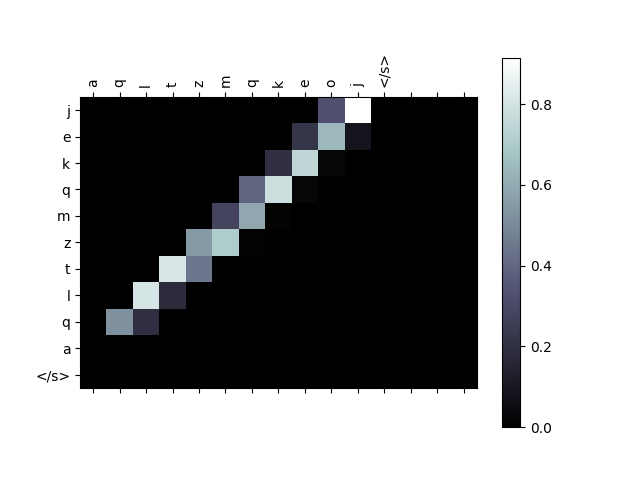

C:\Users\ziipp\AppData\Local\Temp\ipykernel_31920\1632681039.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
C:\Users\ziipp\AppData\Local\Temp\ipykernel_31920\1632681039.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


In [44]:
%matplotlib notebook

evaluateAndShowAttention()